In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2, ToTensor
from torchsummary import summary
from torchmetrics import Accuracy, F1Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter('ignore')

sns.set(style = 'whitegrid', palette = 'Set2')

In [3]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.9 MB/s eta 0:00:00


In [5]:
pip install torchsummary

In [7]:
pip install torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.6 MB/s eta 0:00:00


In [14]:
random_seed = 42
root_dir = '/content/drive/MyDrive/cse498r'
folder_no = '/content/drive/MyDrive/cse498r/normal'
folder_yes = '/content/drive/MyDrive/cse498r/pneumonia'


samples, labels = [], []

# Walk through the directory tree
for root, directories, files in os.walk(root_dir):
    print(f"Current directory: {root}")
    # Print files in the current directory
    for file in files:
        labels.append(1 if 'pneumonia' in root else 0)
        if file not in samples:
            samples.append(os.path.join(root, file))

print(f'\nLength of Samples: {len(samples)}')
print(f'Length of Labels: {len(labels)}')

X_train, X_test, y_train, y_test = train_test_split(np.array(samples), np.array(labels), test_size = 0.2, random_state = random_seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = random_seed)

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

Current directory: /content/drive/MyDrive/cse498r
Current directory: /content/drive/MyDrive/cse498r/pneumonia
Current directory: /content/drive/MyDrive/cse498r/normal

Length of Samples: 629
Length of Labels: 629


((503,), (63,), (63,), (503,), (63,), (63,))

<BarContainer object of 2 artists>

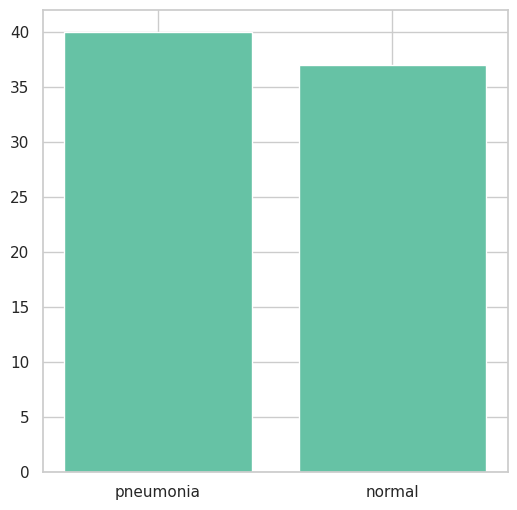

In [15]:
plt.figure(figsize = (6, 6))
plt.bar(['pneumonia', 'normal'], [len(folder_yes), len(folder_no)])

In [17]:
# Create custom dataset
class BrainMRIDataset(Dataset):
    def __init__(self, data, labels, transforms = None):
        self.data = data
        self.targets = labels
        self.transforms = transforms

    def display_samples(self, grid_size = 3, figsize = (10, 10), axis = False):
        fig = plt.figure(figsize = figsize)

        for i in range(grid_size * grid_size):
            rand_idx = np.random.randint(0, len(self.data))

            img, target = Image.open(self.data[rand_idx]).convert('L'), self.targets[rand_idx]
            if self.transforms:
                img = self.transforms(img)
            color = 'green' if self.targets[rand_idx] == 1 else 'red'

            plt.subplot(grid_size, grid_size, i + 1)
            plt.imshow(img.squeeze(), cmap = 'gray')
            plt.title(f"Brain Tumor: {'YES' if self.targets[rand_idx] == 1 else 'NO'}", color = color)
            plt.axis(axis)

            if axis:
                plt.xlabel(f'Index : {rand_idx}')

        fig.tight_layout()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = Image.open(self.data[idx]).convert('L')
        if self.transforms:
            data = self.transforms(data)
        return data, torch.tensor(self.targets[idx], dtype = torch.float32)

transforms = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize((144, 144)),
    v2.RandomVerticalFlip(p = 0.5),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.Normalize(mean=[0.485], std=[0.229]),
])

batch_size = 16

train_data = BrainMRIDataset(X_train, y_train, transforms)
test_data = BrainMRIDataset(X_test, y_test, transforms)
val_data = BrainMRIDataset(X_val, y_val, transforms)

train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = False)
val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle = True)

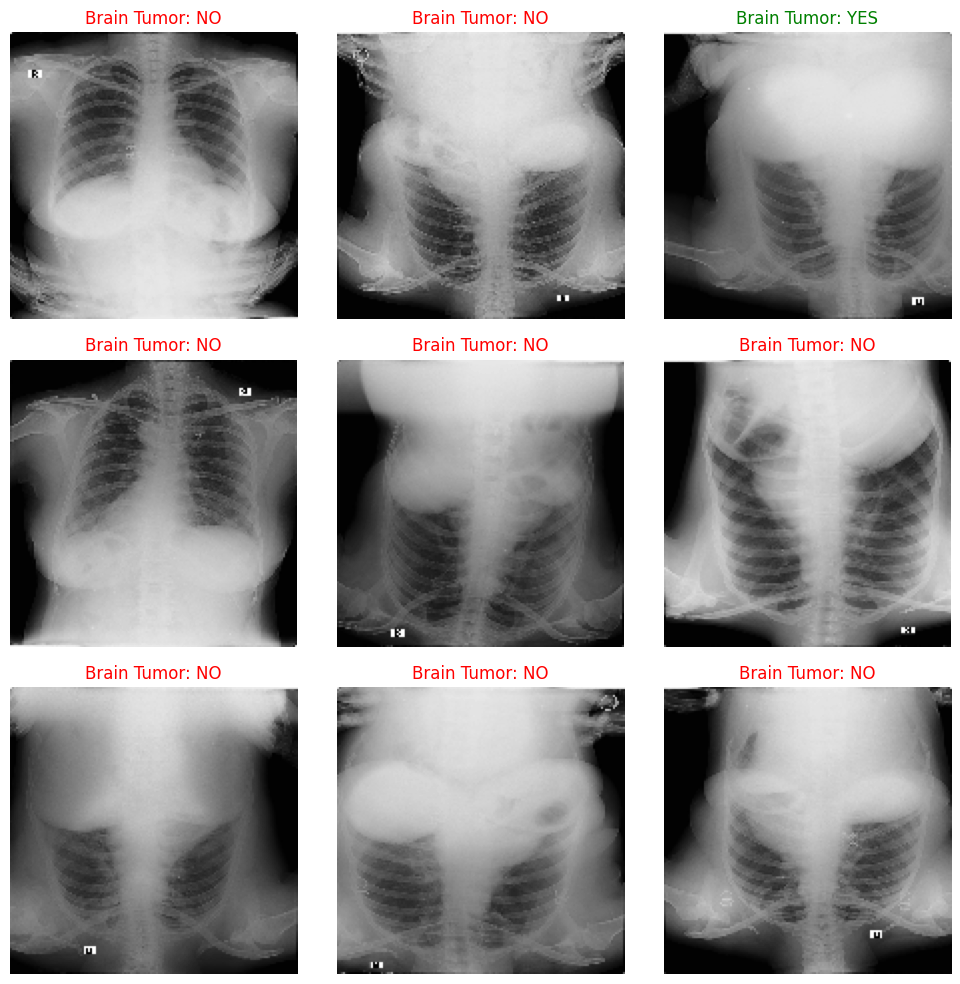

In [18]:
train_data.display_samples()

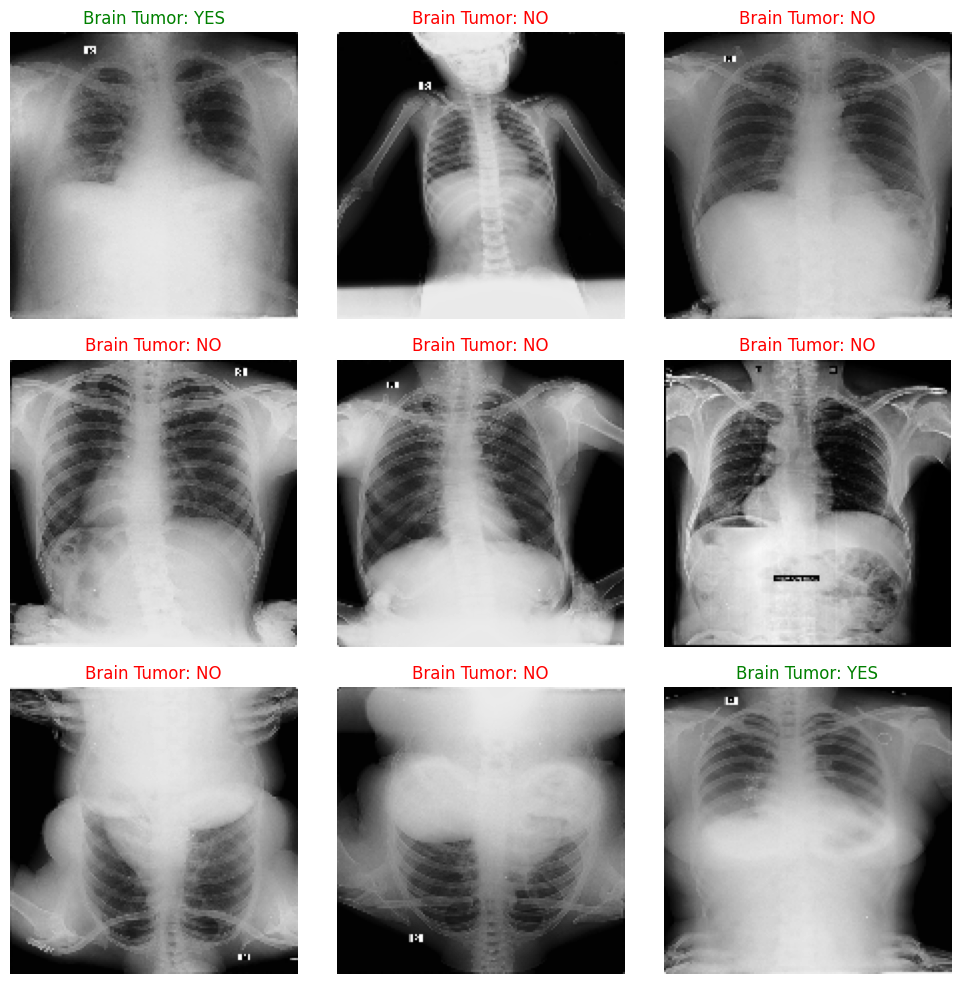

In [19]:
test_data.display_samples()

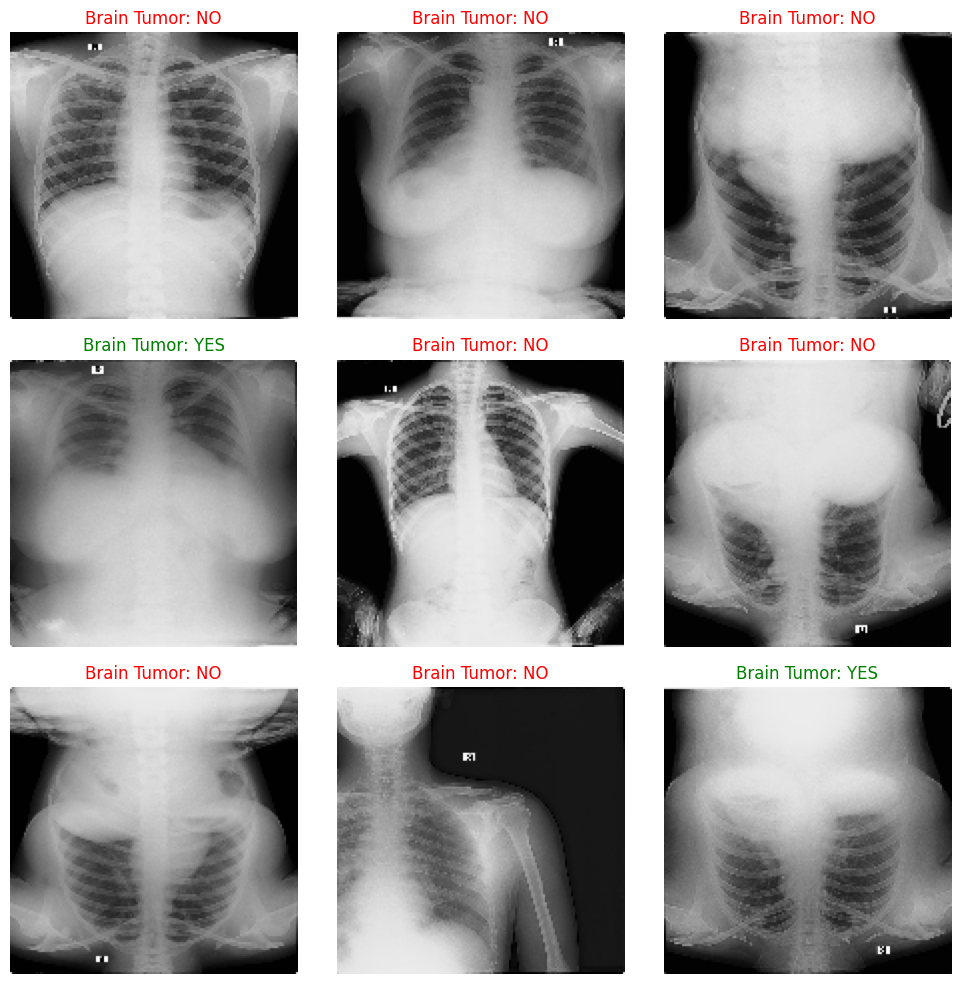

In [20]:
val_data.display_samples()

In [21]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 1, patch_size: int = 16, emb_size: int = 768, img_size = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size = patch_size, stride = patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')) # batch, embeddings, height, width -> batch (height x width) embeddings

        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size)**2+1, emb_size)) # +1, accounting for cls_token

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b = b)
        x = torch.cat([cls_tokens, x], dim = 1)
        x += self.positions
        return x

In [23]:
sample = train_data[0][0].unsqueeze(0) # let's add a batch dimension -> output shape: [1, 1, 144, 144]
embedding = PatchEmbedding(in_channels = sample.shape[0],
                          patch_size = 16,
                          emb_size = 768,
                          img_size = sample.shape[2])(sample)
print(f'Sample Original Shape: {sample.shape}')
print(f'Sample Embedding Shape: {embedding.shape}')

Sample Original Shape: torch.Size([1, 1, 144, 144])
Sample Embedding Shape: torch.Size([1, 82, 768])


In [24]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0.):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads

        self.qkv = nn.Linear(emb_size, emb_size * 3)

        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x, mask = None):
        # 1. Split keys, queries, and values in num_heads
        qkv = rearrange(self.qkv(x), 'b n (h d qkv) -> (qkv) b h n d', h = self.num_heads, qkv = 3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]

        # 2. Sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)

        att = F.softmax(energy, dim = -1) / scaling
        att = self.att_drop(att)

        # Sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav', att, values)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.projection(out)
        return out

In [25]:
MultiHeadAttention()(embedding).shape

torch.Size([1, 82, 768])

In [26]:
class FeedForward(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
            nn.Dropout(drop_p)
        )
ff = FeedForward(emb_size = 768)
ff(embedding).shape

torch.Size([1, 82, 768])

In [27]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [28]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size: int = 768, drop_p: float = 0.1, forward_expansion: int = 4, forward_drop_p: float = 0., **kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            MultiHeadAttention(emb_size, **kwargs),
            nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            FeedForward(emb_size, expansion = forward_expansion, drop_p = forward_drop_p),
            nn.Dropout(drop_p)))
        )

class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [29]:
TransformerEncoderBlock()(embedding).shape

torch.Size([1, 82, 768])

In [30]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1):
        super().__init__(
            Reduce('b n e -> b e', reduction = 'mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

In [31]:
class ViT(nn.Sequential):
    def __init__(self,
                in_channels: int = 1,
                patch_size: int = 4,
                emb_size: int = 32,
                img_size: int = 144,
                depth: int = 2,
                n_classes: int = 1,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size = emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [33]:
summary(ViT(), (1, 144, 144), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 36, 36]             544
         Rearrange-2             [-1, 1296, 32]               0
    PatchEmbedding-3             [-1, 1297, 32]               0
         LayerNorm-4             [-1, 1297, 32]              64
            Linear-5             [-1, 1297, 96]           3,168
           Dropout-6        [-1, 8, 1297, 1297]               0
            Linear-7             [-1, 1297, 32]           1,056
MultiHeadAttention-8             [-1, 1297, 32]               0
           Dropout-9             [-1, 1297, 32]               0
      ResidualAdd-10             [-1, 1297, 32]               0
        LayerNorm-11             [-1, 1297, 32]              64
           Linear-12            [-1, 1297, 128]           4,224
             GELU-13            [-1, 1297, 128]               0
          Dropout-14            [-1, 12

In [34]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

model = ViT().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.BCEWithLogitsLoss()
acc_fn = Accuracy(task = 'binary').to(device)
f1_fn = F1Score(task = 'binary').to(device)

In [35]:
def train(model, dataloader, loss_fn, metric_fn, optimizer, device):
    loss, metric_score = 0, 0

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        logits = model(X).squeeze()

        batch_loss = loss_fn(logits, y)
        metric_score += metric_fn(logits, y)

        loss += batch_loss

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    loss /= len(dataloader)
    metric_score /= len(dataloader)

    print(f'Training -- Loss: {loss:.4f}, F1: {metric_score*100:.2f}%')

def validate(model, dataloader, loss_fn, metric_fn, device):
    loss, metric_score = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            logits = model(X).squeeze()
            loss += loss_fn(logits, y)
            metric_score += metric_fn(logits, y)

        loss /= len(dataloader)
        metric_score /= len(dataloader)

        print(f'Validation -- Loss: {loss:.4f}, F1: {metric_score*100:.2f}%')

In [36]:
epochs = 25
for epoch in range(epochs):
    print(f'Epoch : # {epoch}')
    print('-'*30+'\n')

    train(model,
         train_dataloader,
         loss_fn,
         f1_fn,
         optimizer,
         device)

    validate(model,
            val_dataloader,
            loss_fn,
            f1_fn,
            device)

    print('\n')

Epoch : # 0
------------------------------

Training -- Loss: 0.4857, F1: 2.24%
Validation -- Loss: 0.4401, F1: 0.00%


Epoch : # 1
------------------------------

Training -- Loss: 0.4321, F1: 0.00%
Validation -- Loss: 0.4279, F1: 0.00%


Epoch : # 2
------------------------------

Training -- Loss: 0.4351, F1: 0.00%
Validation -- Loss: 0.4274, F1: 0.00%


Epoch : # 3
------------------------------

Training -- Loss: 0.4406, F1: 0.00%
Validation -- Loss: 0.4313, F1: 0.00%


Epoch : # 4
------------------------------

Training -- Loss: 0.4464, F1: 0.00%
Validation -- Loss: 0.4401, F1: 0.00%


Epoch : # 5
------------------------------

Training -- Loss: 0.4335, F1: 0.00%
Validation -- Loss: 0.4352, F1: 0.00%


Epoch : # 6
------------------------------

Training -- Loss: 0.4362, F1: 0.00%
Validation -- Loss: 0.4323, F1: 0.00%


Epoch : # 7
------------------------------

Training -- Loss: 0.4264, F1: 0.00%
Validation -- Loss: 0.4349, F1: 0.00%


Epoch : # 8
----------------------------

KeyboardInterrupt: ignored

In [37]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 61.5 MB/s eta 0:00:00


In [38]:
import os
import shutil
import tempfile
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

In [39]:
data_dir = '/content/drive/MyDrive/cse498r'
class_names0 = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
class_names=['normal', 'pneumonia']

num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x)
                for x in os.listdir(os.path.join(data_dir, class_name))]
               for class_name in class_names]
print(class_names)

['normal', 'pneumonia']


In [40]:
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
print(image_file_list[0:10])

['/content/drive/MyDrive/cse498r/normal/x-ray (591).jpg', '/content/drive/MyDrive/cse498r/normal/x-ray (618).jpg', '/content/drive/MyDrive/cse498r/normal/x-ray (630).jpg', '/content/drive/MyDrive/cse498r/normal/x-ray (625).jpg', '/content/drive/MyDrive/cse498r/normal/x-ray (628).jpg', '/content/drive/MyDrive/cse498r/normal/x-ray (584).jpg', '/content/drive/MyDrive/cse498r/normal/x-ray (604).jpg', '/content/drive/MyDrive/cse498r/normal/x-ray (608).jpg', '/content/drive/MyDrive/cse498r/normal/x-ray (602).jpg', '/content/drive/MyDrive/cse498r/normal/x-ray (586).jpg']


In [41]:
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 629
Image dimensions: 1760 x 2140
Label names: ['normal', 'pneumonia']
Label counts: [515, 114]


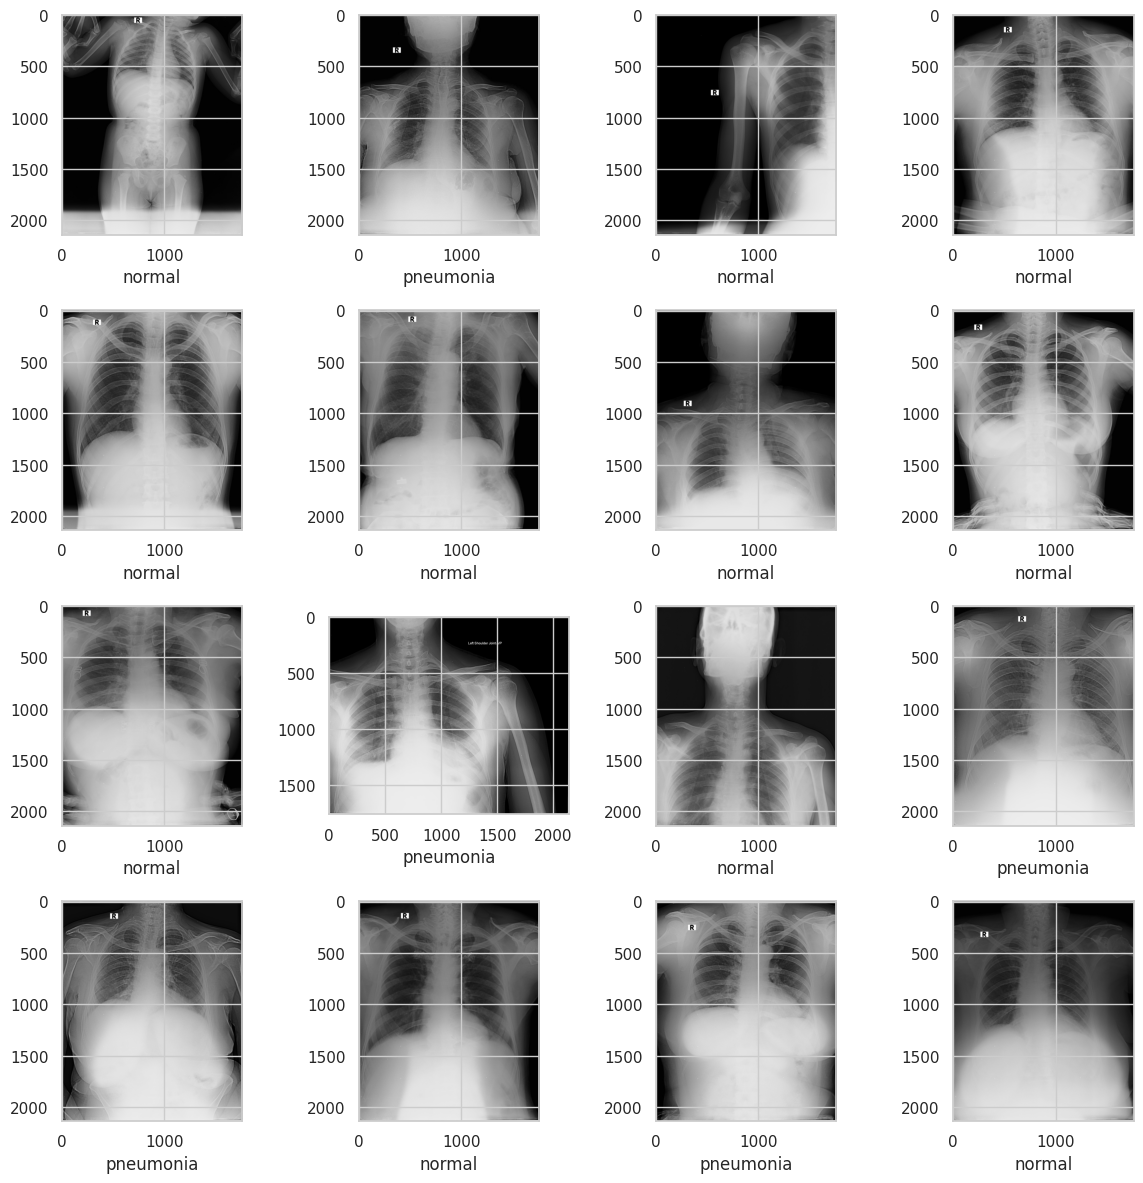

In [42]:
plt.subplots(4,4, figsize=(12,12))
for i,k in enumerate(np.random.randint(num_total, size=16)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(4,4, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [43]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print(len(trainX),len(valX),len(testX))

520 50 59


**Define MONAI transforms, Dataset and Dataloader to pre-process data**

In [44]:
class MyResize(Transform):
    def __init__(self, size=(160,160)):
        self.size = size
    def __call__(self, inputs):
        image2=cv2.resize(inputs,dsize=(self.size[1],self.size[0]),interpolation=cv2.INTER_CUBIC)
        return image2

In [47]:
from monai.transforms import LoadImage, AddChannel, ScaleIntensity, RandRotate, RandFlip, RandZoom, ToTensor, Resize


ImportError: ignored

In [52]:
!pip install monai-weekly

In [53]:
from monai.transforms import LoadImage, AddChannel, ScaleIntensity, RandRotate, RandFlip, RandZoom, ToTensor, Resize

ImportError: ignored

In [51]:
from monai.transforms import LoadImage, AddChannel, ScaleIntensity, RandRotate, RandFlip, RandZoom, ToTensor, Resize

ImportError: ignored

In [54]:
!git clone https://github.com/Project-MONAI/MONAI.git
!cd MONAI && git checkout weekly
!pip install -e .

Cloning into 'MONAI'...
remote: Enumerating objects: 37073, done.
remote: Counting objects: 100% (327/327), done.
remote: Compressing objects: 100% (230/230), done.
remote: Total 37073 (delta 195), reused 183 (delta 97), pack-reused 36746
Receiving objects: 100% (37073/37073), 64.21 MiB | 21.21 MiB/s, done.
Resolving deltas: 100% (29750/29750), done.
error: pathspec 'weekly' did not match any file(s) known to git
Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [55]:
LoadImage(image_only=True),
AddChannel,
ScaleIntensity(),
RandRotate(range_x=15, prob=0.5, keep_size=True),
RandFlip(spatial_axis=0, prob=0.5),
RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
ToTensor(),
Resize(spatial_size=(-1,64,64,3))

NameError: ignored